In [3]:
# MNIST Dataset: Machine Learning and Deep Learning Model Comparison

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Load and prepare the dataset
print("Loading MNIST dataset...")
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data (0-1 range)
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training data shape: {x_train_full.shape}")
print(f"Test data shape: {x_test.shape}")

# Flatten data for machine learning models
x_train_flat = x_train_full.reshape(x_train_full.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Reduce training data to smaller subset (for speed)
# Using first 10,000 samples since full dataset is very large
n_samples = 10000
x_train_sample = x_train_flat[:n_samples]
y_train_sample = y_train_full[:n_samples]

print(f"\nAfter sampling, training data shape: {x_train_sample.shape}")


Loading MNIST dataset...
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)

After sampling, training data shape: (10000, 784)


In [4]:
# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'{title} - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    
    return cm


1. TRAINING RANDOM FOREST MODEL
Starting Random Forest training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Making Random Forest predictions...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.96      0.94      0.95       982
           5       0.96      0.93      0.94       892
           6       0.95      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.92      0.94      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



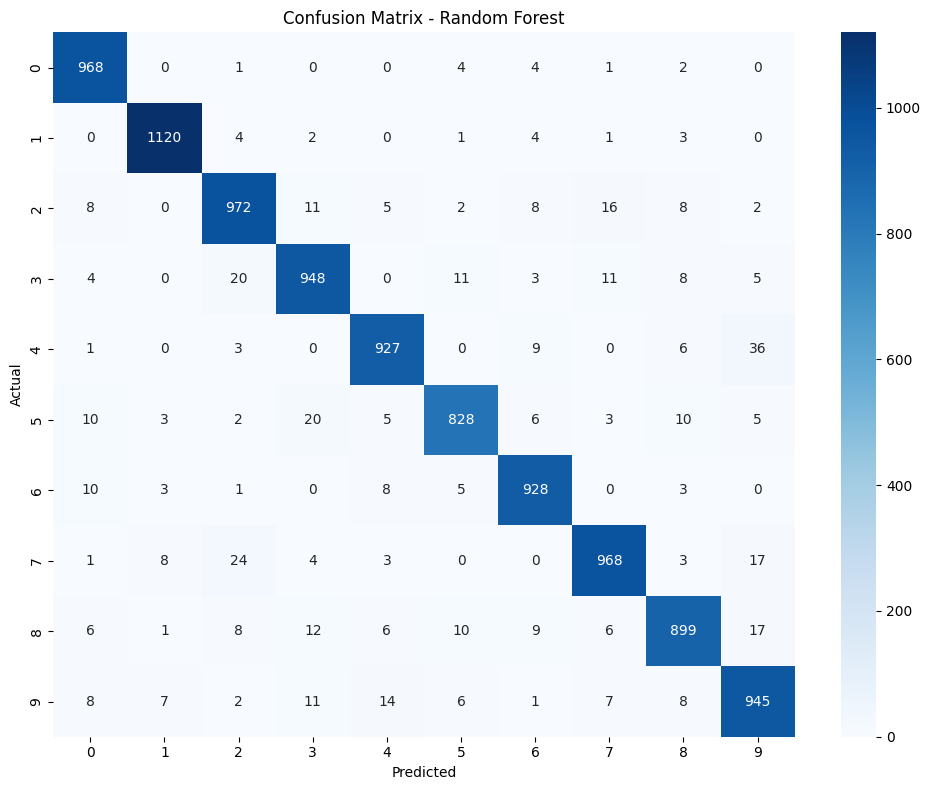


Random Forest Accuracy: 0.9503


In [5]:
# 1. RANDOM FOREST MODEL
print("\n" + "="*50)
print("1. TRAINING RANDOM FOREST MODEL")
print("="*50)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting Random Forest training...")
rf_model.fit(x_train_sample, y_train_sample)

print("Making Random Forest predictions...")
rf_predictions = rf_model.predict(x_test_flat)

# Random Forest results
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Random Forest Confusion Matrix
rf_cm = plot_confusion_matrix(y_test, rf_predictions, 
                             "Confusion Matrix", "Random Forest")


2. TRAINING XGBOOST MODEL
Starting XGBoost training...
Making XGBoost predictions...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.96      0.93      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.93      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



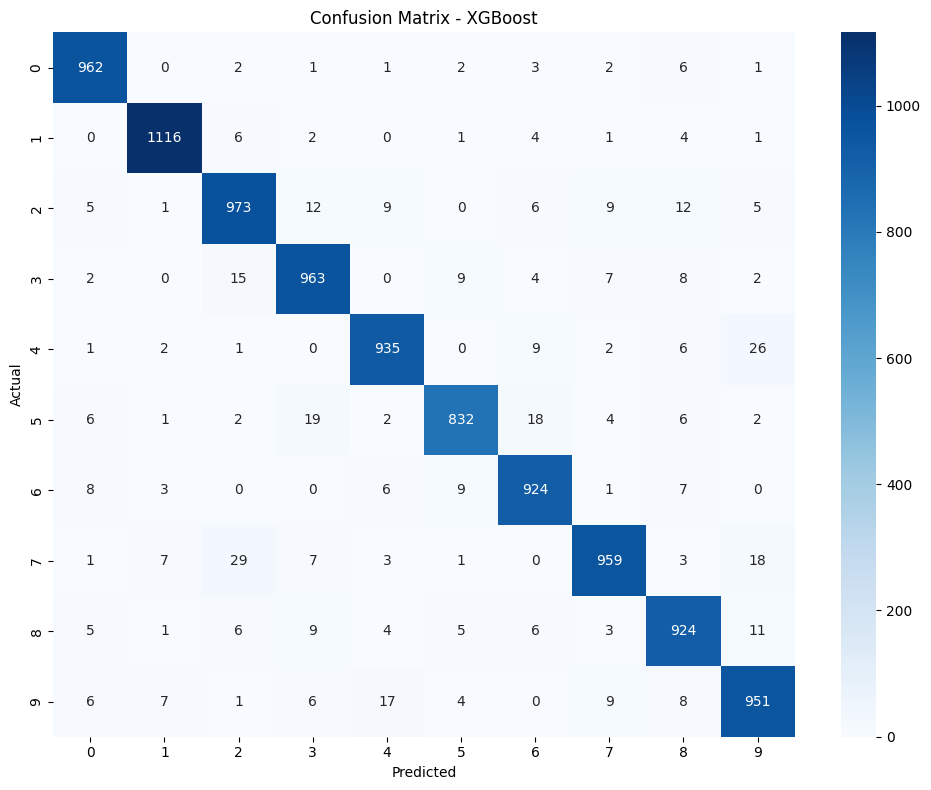


XGBoost Accuracy: 0.9539

3. TRAINING CNN MODEL


In [6]:
# 2. XGBOOST MODEL
print("\n" + "="*50)
print("2. TRAINING XGBOOST MODEL")
print("="*50)

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=10,
    n_estimators=100,
    random_state=42,
    verbosity=1
)

print("Starting XGBoost training...")
xgb_model.fit(x_train_sample, y_train_sample)

print("Making XGBoost predictions...")
xgb_predictions = xgb_model.predict(x_test_flat)

# XGBoost results
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

# XGBoost Confusion Matrix
xgb_cm = plot_confusion_matrix(y_test, xgb_predictions, 
                              "Confusion Matrix", "XGBoost")

# 3. CNN (CONVOLUTIONAL NEURAL NETWORK) MODEL
print("\n" + "="*50)
print("3. TRAINING CNN MODEL")
print("="*50)

# Reshape data for CNN
x_train_cnn = x_train_full[:n_samples].reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)
y_train_cnn = y_train_full[:n_samples]

CNN Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (

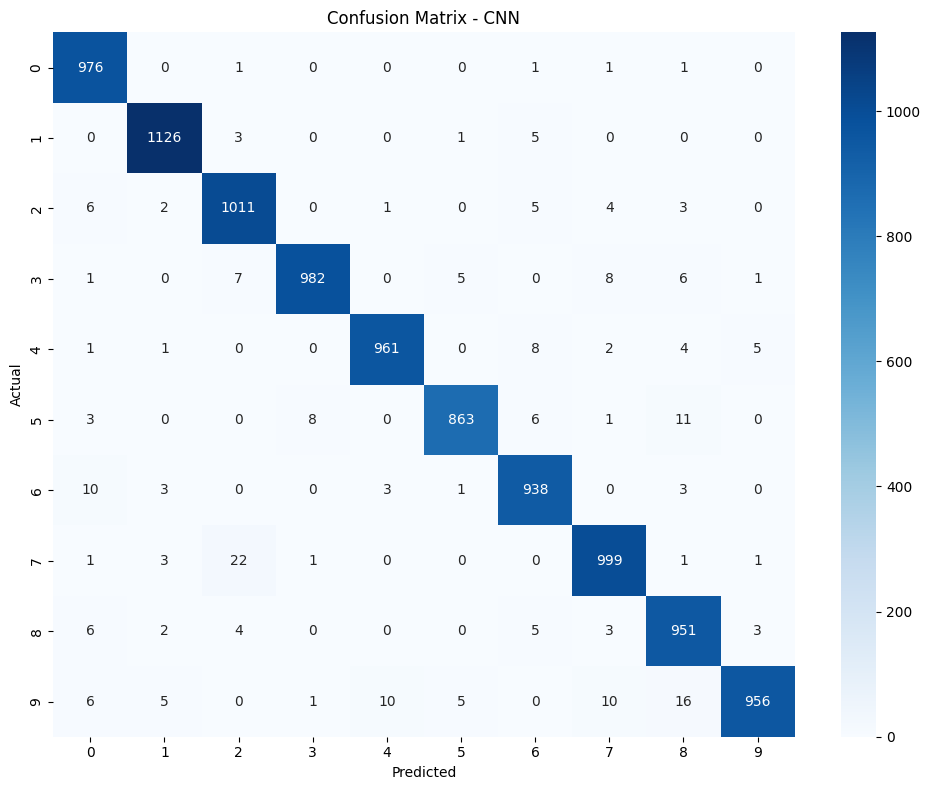


CNN Accuracy: 0.9763


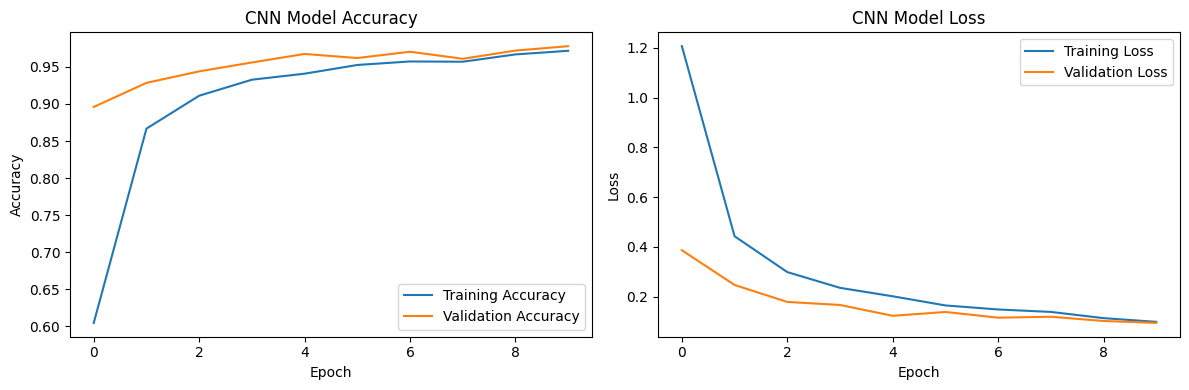

In [7]:
# Build CNN model
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile CNN model
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model Architecture:")
cnn_model.summary()

# Train CNN model
print("\nStarting CNN training...")
history = cnn_model.fit(
    x_train_cnn, y_train_cnn,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# CNN predictions
print("Making CNN predictions...")
cnn_predictions_proba = cnn_model.predict(x_test_cnn)
cnn_predictions = np.argmax(cnn_predictions_proba, axis=1)

# CNN results
print("\nCNN Classification Report:")
print(classification_report(y_test, cnn_predictions))

# CNN Confusion Matrix
cnn_cm = plot_confusion_matrix(y_test, cnn_predictions, 
                              "Confusion Matrix", "CNN")

# Visualize CNN training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


4. MODEL COMPARISON RESULTS

Model Accuracy Comparison:
           Model  Accuracy
0  Random Forest    0.9503
1        XGBoost    0.9539
2            CNN    0.9763


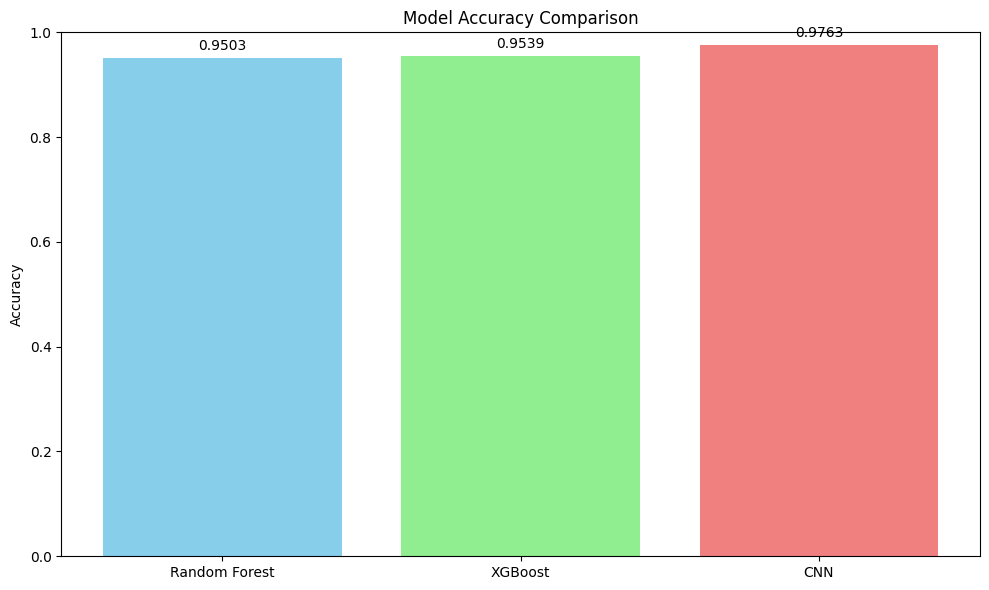

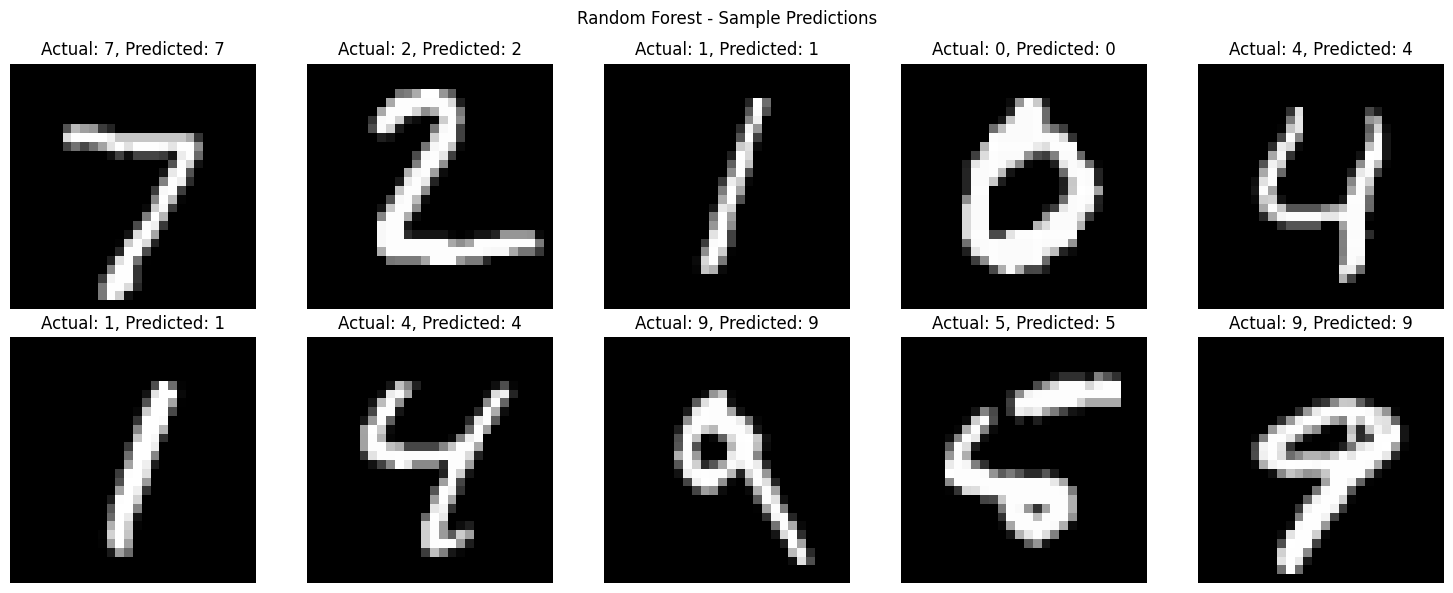

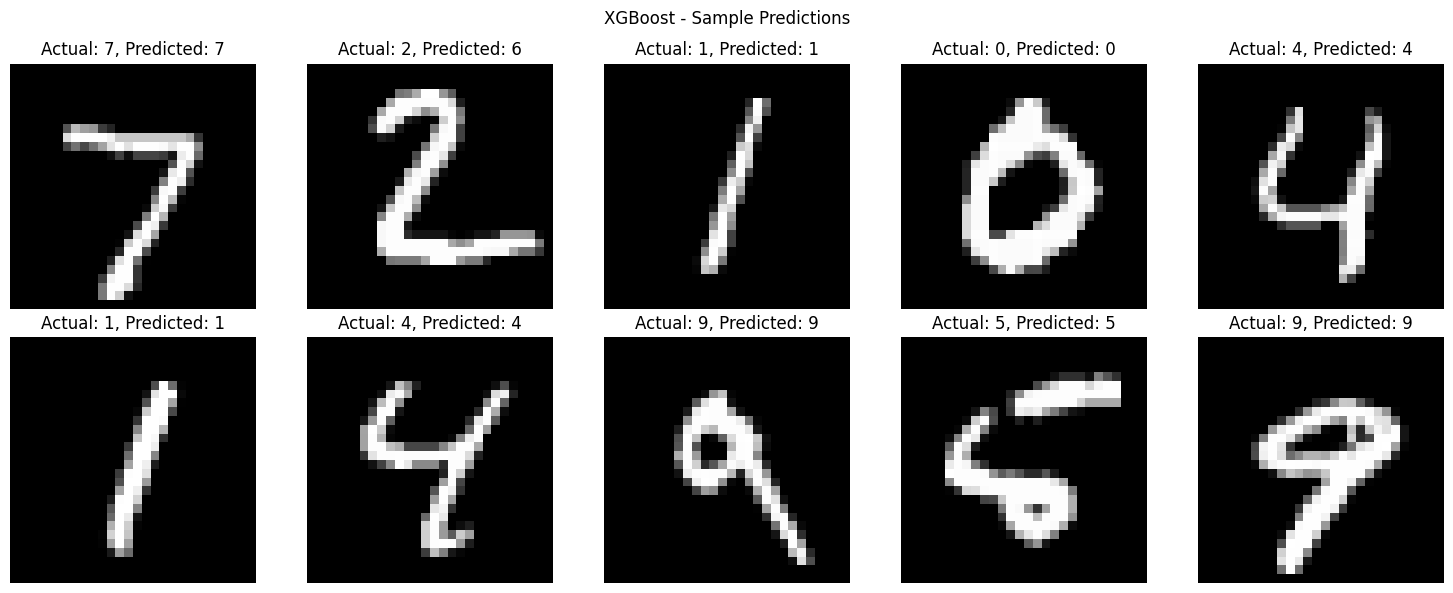

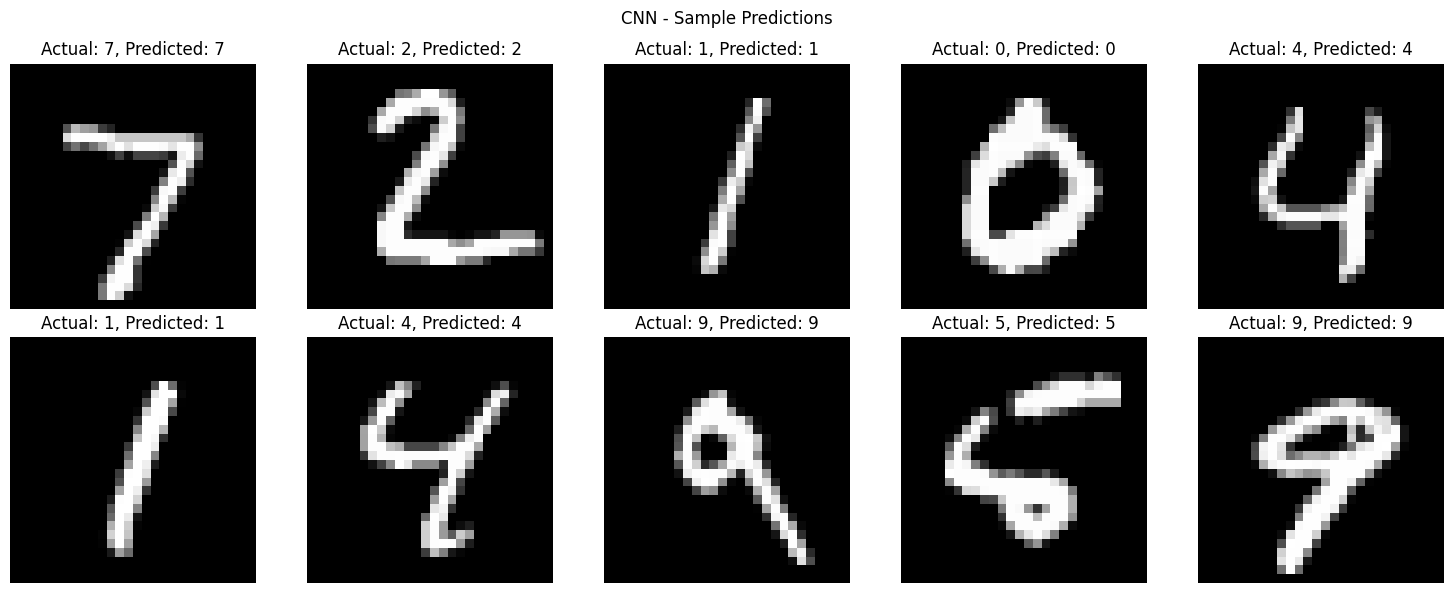


ANALYSIS COMPLETED!
Best performing model: CNN
Highest accuracy: 0.9763


In [8]:
# 4. MODEL COMPARISON
print("\n" + "="*50)
print("4. MODEL COMPARISON RESULTS")
print("="*50)

# Compare accuracy values
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
cnn_accuracy = accuracy_score(y_test, cnn_predictions)

results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'CNN'],
    'Accuracy': [rf_accuracy, xgb_accuracy, cnn_accuracy]
})

print("\nModel Accuracy Comparison:")
print(results_df)

# Visualize results
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], 
               color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Show values on bars
for bar, accuracy in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Visualize sample predictions
def show_sample_predictions(model_name, predictions, n_samples=10):
    plt.figure(figsize=(15, 6))
    for i in range(n_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_test[i], cmap='gray')
        plt.title(f'Actual: {y_test[i]}, Predicted: {predictions[i]}')
        plt.axis('off')
    plt.suptitle(f'{model_name} - Sample Predictions')
    plt.tight_layout()
    plt.show()

# Show sample predictions for each model
show_sample_predictions('Random Forest', rf_predictions)
show_sample_predictions('XGBoost', xgb_predictions)
show_sample_predictions('CNN', cnn_predictions)

print("\n" + "="*50)
print("ANALYSIS COMPLETED!")
print("="*50)
print(f"Best performing model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
print(f"Highest accuracy: {results_df['Accuracy'].max():.4f}")